Grace Chiu
# Kaggle Report

## What you tried. What worked, what did not work. What your main challenges were

### First load data and look at the target labels

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Read in training data with Id column and store training label
df=pd.read_csv('train_final.csv', index_col='Id')
y_label = df.loc[:, 'Y']
df_all = df.copy()
df=df.drop(columns=['Y'])
print(len(y_label))
print(df.shape) # 16383 training data with 24 features
pd.set_option('display.max_columns',30)

# Read in test data with Id column
df_test = pd.read_csv('test_final.csv', index_col='Id')
print(df_test.shape) # 16385 predictions we have to make

16383
(16383, 24)
(16385, 24)


In [4]:
# Look at distribution of 0 and 1 of target from train set
print(df_all['Y'].value_counts())
print("\nPercentage of data with y = 0: ", round(100*df_all['Y'].value_counts()[0] / df_all['Y'].value_counts().sum(),2), "%")

1    15435
0      948
Name: Y, dtype: int64

Percentage of data with y = 0:  5.79 %


### Try 1: Use Standard Scaler, then 2-component PCA, then Logistic Regression (did not work)

In [5]:
# Get means of features of 0 and 1 label groups
df_all.groupby('Y').mean()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24
Y,,,,,,,,,,,,,,,,,,,,,,,,
0,43068.039030,1.045359,8.231994,118324.258439,1.041139,0.031646,117342.818565,168077.553797,1.042194,3.960970,1.033755,4.165612,119371.185654,0.075633,26453.470464,118853.156118,187304.179325,1.045359,125842.572785,1.032700,1.041139,1.040084,501.392405,1.026371
1,43004.074571,1.044315,11.988295,118323.539877,1.044639,0.051182,117074.126271,169831.680920,1.041788,5.038678,1.043019,6.514286,119799.067250,0.307348,25859.974344,119056.887917,184457.306965,1.047425,125966.859605,1.045287,1.045999,1.042047,34697.665436,1.045028


When comparing feature values among the two label groups, most features appear to be similar. f3 and f10 have more differences compared to other features. f23 shows a strong difference. Below, we dig further into the f23 feature. 

In [6]:
df_all.loc[df_all['Y'] == 0]['f23'].describe()

count       948.000000
mean        501.392405
std       10366.021778
min           1.000000
25%           1.000000
50%           2.000000
75%           9.000000
max      315918.000000
Name: f23, dtype: float64

In [7]:
df_all.loc[df_all['Y'] == 1]['f23'].describe()

count    1.543500e+04
mean     3.469767e+04
std      3.281273e+06
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      9.000000e+00
max      4.042886e+08
Name: f23, dtype: float64

I was going to heavily weight feature f23 in my model for predicting labels 0 and 1, since the mean statistics appear to be drastically different between the two classes, therefore a good candidate for prediction at the first glance. However, after digging more into the data where I get the summary statistics of the f23 data, it seems that the mean for Y = 1 is drastically higher than the Y = 0 class because there are multiple values that are drastically high, bringing the high difference in the means. Not only that the max and standard deviation is different, we can observe that the distributions are not too different with the same values of min, 25% quartile, median, and 75% quartile. 

This is kind of disappointing to find, but here is an opportunity to scale the feature, so the model does not get skewed with the large anomaly values in this particular feature.

In [8]:
# Scale f23 in train and test
# Subtract each value from its minimum and divide by the difference of its maximum and its minimum
df_scale23 = df_all.copy()
df_scale23 = df_scale23.drop(labels=['Y'], axis=1)
df_scale23.loc[:, 'f23'] = (df_scale23.loc[:, 'f23'] - df_scale23.loc[:,'f23'].min()) / (df_scale23.loc[:,'f23'].max() - df_scale23.loc[:,'f23'].min())
print(df_scale23.shape) # Make sure f23 is transformed

df_test_scale23 = df_test.copy()
df_test_scale23.loc[:, 'f23'] = (df_test_scale23.loc[:, 'f23'] - df_test_scale23.loc[:,'f23'].min()) / (df_test_scale23.loc[:,'f23'].max() - df_test_scale23.loc[:,'f23'].min())
print(df_test_scale23.shape)

(16383, 24)
(16385, 24)


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [10]:
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(random_state=1,solver='lbfgs'))])
pipe_lr.fit(df_scale23, y_label)
y_pred_prob_scale23 = pipe_lr.predict_proba(df_test_scale23)[:, 1]

In [11]:
output_scale23 = pd.DataFrame({'Id':df_test_scale23.index, 'Y':y_pred_prob_scale23})
output_scale23.head()
#output_scale23.to_csv("output_scale23.csv", index = False)

,Id,Y
0,16384,0.941283
1,16385,0.948281
2,16386,0.948168
3,16387,0.939666
4,16388,0.942018


This gives an <b>AUC of 0.50164 from public LB</b> on day 1, which is as good as randomly guessing. 

After going to office hours, I learned that logistic regression would not work well if the data is in numerical format. I was also told that we should only do feature engineering after we have a good base model. 

### Try 2: One-hot encode categorical features and predict with Random Forest and XGBoost (did not work too well)

I counted the number of unique values for each feature and set the threshold as 30. So if there are fewer than 30 unique values in a feature, then the feature is categorical, and I will apply one-hot encoding; otherwise, the feature is numerical. In addition, 'f3' is also a categorical feature for me, since I saw that the 'f3' feature seems to be a multiple of 1.77, and the multiples will be the class that the data belongs to. 

I one-hot encoded the training and testing data. 

In [12]:
# Observe if there are any potnetial categorical columns
diff_vals = []
non_cat_f = []
cat_f = []
for col in df.columns[1:]: # skip Y label column
    val = df.loc[:,col].value_counts().shape[0]
    diff_vals.append(val)
    if col == 'f3':
        cat_f.append(col)
    if val < 30: # if there are fewer than 30 distinct values of a column, then consider them as categorical
        cat_f.append(col)
    else:
        non_cat_f.append(col)

# Print column name/ feature name and number of different values of the column
print('Potential categorical features')    
for f in cat_f:
    val = df.loc[:,f].value_counts().shape[0]
    print(f, val)
    print(df.loc[:,f].value_counts())
    
print('\nLikely non-categorical features')              
for f in non_cat_f:
    val = df.loc[:,f].value_counts().shape[0]
    print(f, val)

Potential categorical features
f2 7
1    15807
2      479
3       60
4       24
5       10
6        2
7        1
Name: f2, dtype: int64
f3 168
1.77       10031
3.54        2466
5.31        1053
7.08         596
8.85         411
           ...  
1007.13        1
297.36         1
228.33         1
283.20         1
479.67         1
Name: f3, Length: 168, dtype: int64
f5 8
1    15795
2      499
3       60
4       16
5        9
7        2
6        1
9        1
Name: f5, dtype: int64
f6 9
0     15745
1       522
2        80
3        24
5         6
4         3
6         1
10        1
8         1
Name: f6, dtype: int64
f9 7
1     15839
2       441
3        80
4        16
5         5
7         1
11        1
Name: f9, dtype: int64
f11 7
1    15816
2      483
3       54
4       21
5        5
6        3
8        1
Name: f11, dtype: int64
f18 9
1     15778
2       505
3        68
4        20
5         5
6         3
7         2
11        1
18        1
Name: f18, dtype: int64
f20 7
1    15801
2      4

In [13]:
# Convert category like columns into category type columns
print(cat_f)
df_onehot = df.copy()
for f in cat_f:
    df_onehot[f] = df_onehot[f].astype('category')

df_onehot=pd.get_dummies(df_onehot)
print(df_onehot.shape)

# Convert category like columns into category type columns
df_test_onehot = df_test.copy()
for f in cat_f:
    df_test_onehot[f] = df_test_onehot[f].astype('category')

df_test_onehot=pd.get_dummies(df_test_onehot)
print(df_test_onehot.shape)

['f2', 'f3', 'f5', 'f6', 'f9', 'f11', 'f18', 'f20', 'f21', 'f22', 'f24']
(16383, 257)
(16385, 259)


Now observe that after one-hot encoded the data, the shape is different, and the difference will prohibit us from fitting and predicting the data. The difference arose from the categorical features having different values. To solve this, I get rid of features from each other that the other data does not possess. 

In [14]:
# Get rid of features from train data that test data do not have
for i in df_onehot.columns:
    if i not in df_test_onehot.columns:
        df_onehot=df_onehot.drop(columns=[i])
    
# Get rid of features from test data that train data do not have        
for i in df_test_onehot.columns:
    if i not in df_onehot.columns:
        df_test_onehot=df_test_onehot.drop(columns=[i])
        
print(df_onehot.shape)
print(df_test_onehot.shape)

(16383, 176)
(16385, 176)


Now with the two dataset being the same size, I have no problem in fitting and predicting using the model. I also used stratified k-fold to help guide my decisions. I used stratified to make sure I have a equal amount of 0s and 1s in each training set, so my model is not overly influenced with the copious label 1 data. 

In [15]:
from statistics import mean
from sklearn.model_selection import StratifiedKFold

def eval_skf(lst_accu_stratified, rocs):
    print('List of ROCs:', rocs)
    print('Overall ROCs:',
        mean(rocs)*100, '%')

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

depths = [3,4,5]
for d in depths:
    rf_model2 = RandomForestClassifier(max_depth=d, random_state=42)

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    skf_rf2_scores = []
    skf_rf2_rocs = []

    for train_index, test_index in skf.split(df_onehot, y_label):
        x_train_fold, x_test_fold = df_onehot.iloc[train_index,], df_onehot.iloc[test_index,]
        y_train_fold, y_test_fold = y_label.iloc[train_index], y_label.iloc[test_index]
        rf_model2.fit(x_train_fold, y_train_fold)
        skf_rf2_scores.append(rf_model2.score(x_test_fold, y_test_fold))
        skf_rf2_rocs.append(roc_auc_score(y_test_fold, rf_model2.predict_proba(x_test_fold)[:,1]))
    
    print("Max_depth = ", d)
    eval_skf(skf_rf2_scores, skf_rf2_rocs)

Max_depth =  3
List of ROCs: [0.6645418598309245, 0.7381919825470411, 0.6951322607035724, 0.7732471612832101, 0.7417663432918091, 0.7268547259269367, 0.7007504178463008, 0.7488692567452331, 0.7498106900433198, 0.7012791213289218]
Overall ROCs: 72.4044381954727 %
Max_depth =  4
List of ROCs: [0.6986842105263158, 0.7525429506408507, 0.7101377147532042, 0.7729129919523756, 0.7613652022930217, 0.7537128628440837, 0.7367943514002115, 0.757997066548419, 0.7479687553296721, 0.7213289217859944]
Overall ROCs: 74.13445028074149 %
Max_depth =  5
List of ROCs: [0.7183528770111808, 0.7671052631578947, 0.7087810199072813, 0.7824867710285525, 0.7848362914783376, 0.7716410273902514, 0.7285909199440599, 0.7870314152198383, 0.7514104444520244, 0.7608759422860456]
Overall ROCs: 75.61111971875467 %


I chose random forest classifier with a max_depth of 4 because I have tested my model prediction performance with max_depth = 3, 4, and 5. These models give me 72.4%, 74.1%, 75.6% overall ROCs. So I selected model with max_depth = 4 because it shows improvement from depth = 3, but max_depth = 5 shows somewhat a high score that I fear with a slight possibility of overfitting. 

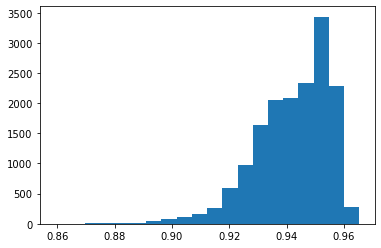

,Id,Y
0,16384,0.940561
1,16385,0.925208
2,16386,0.952162
3,16387,0.949501
4,16388,0.941420


In [17]:
rf_model2 = RandomForestClassifier(max_depth=4, random_state=42)
rf_model2.fit(df_onehot, y_label)
y_pred_prob_rf2 = rf_model2.predict_proba(df_test_onehot)[:, 1]
plt.hist(y_pred_prob_rf2, bins=20)
plt.show()

output_rf2 = pd.DataFrame({'Id':df_test.index, 'Y':y_pred_prob_rf2})
#output_rf2.to_csv("output_rf1.csv", index = False)
output_rf2.head()

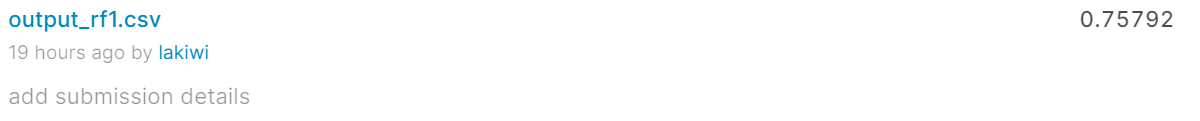

In [18]:
from IPython.display import Image
Image(filename = "rf1.png", width=900)
# One-hot encoded training data with random forest model max_depth = 4

<b>Random forest of 0.75792</b> was an increase from the <b>previous logistic regression model 0.50164</b>.

However, I want to try XGBoost model as well. It was surprising to me that I did not improve with XGB predictions fitted with one-hot encoded training data than the original training data. I got <b>one-hot score of 0.87886</b> which is lower than the <b>original of 0.87929</b>. 

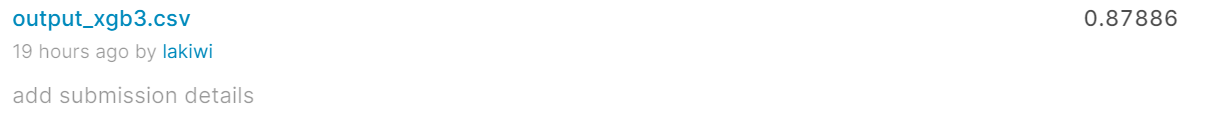

In [19]:
from IPython.display import Image
Image(filename = "xgb3.png", width=900)
# One-hot encoded training data with xgb model

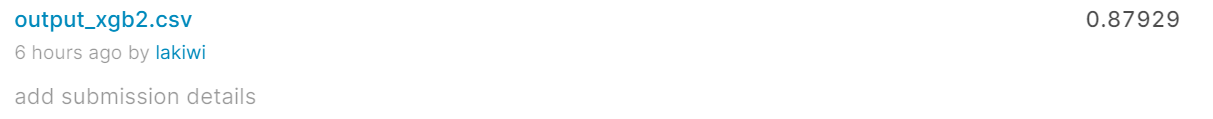

In [20]:
from IPython.display import Image
Image(filename = "xgb2.png", width=900)
# Original training data with xgb model

I also learned in office hours that we should only do feature engineering with a good model, so I was able to get XGBoost working and achieve 0.87929 on the public LB. From then on, I worked to improve the XGB model. 

### Try 3: Use pseudo labeling (somewhat worked)

Pseudo labeling is done through first fitting the XGBoost model with train data and use that model to predict the labels for test data. Then concatenate the train and test data, as well as the y labels (given and predicted), so I can benefit from the rich data that the test data possess. I continue to use the XGBoost model that I used before that gave me a 0.87929 AUC score since I was satisfied with the performance.

In [21]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score

xgb_model3 = xgb.XGBClassifier(random_state=42, eval_metric='auc', use_label_encoder=False)
xgb_model3.fit(df_onehot, y_label)
y_pred_prob_xgb3_1 = xgb_model3.predict_proba(df_onehot)[:,1]
y_pred_prob_xgb3_2 = xgb_model3.predict_proba(df_test_onehot)[:,1]
y_pred_prob_new = np.concatenate([y_pred_prob_xgb3_1, y_pred_prob_xgb3_2])
print(y_pred_prob_new.shape) # This is the predicted probability of train and test

# Concat the train and test dataframe together
df_onehot_train_new = df_onehot.copy()
df_onehot_train_new = df_onehot_train_new.append(df_test_onehot)
print(df_onehot_train_new.shape)

y_pred_xgb3 = xgb_model3.predict(df_test_onehot)
y_label_new = np.concatenate([y_label, y_pred_xgb3])
print(y_label_new.shape) # This is the pseudo label with test data and train

(32768,)
(32768, 176)
(32768,)


In [22]:
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='auc', use_label_encoder=False)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
skf_xgb_scores = []
skf_xgb_rocs = []

for train_index, test_index in skf.split(df_onehot_train_new, y_label_new):
    x_train_fold, x_test_fold = df_onehot_train_new.iloc[train_index,], df_onehot_train_new.iloc[test_index,]
    y_train_fold, y_test_fold = y_label_new[train_index], y_label_new[test_index]
    xgb_model.fit(x_train_fold, y_train_fold)
    skf_xgb_scores.append(xgb_model.score(x_test_fold, y_test_fold))
    skf_xgb_rocs.append(roc_auc_score(y_test_fold, xgb_model.predict_proba(x_test_fold)[:,1]))
    
eval_skf(skf_xgb_scores, skf_xgb_rocs)

List of ROCs: [0.8880883557354144, 0.8950739509563038, 0.9103964927494339, 0.8976983668160139, 0.9246182010887893, 0.9143108348990702, 0.9055258467023174, 0.8888880859469095, 0.9118727169019042, 0.9099006055898737]
Overall ROCs: 90.4637345738603 %


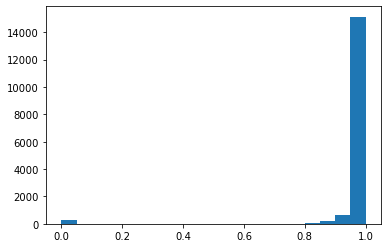

,Id,Y
0,16384,0.969925
1,16385,0.966677
2,16386,0.999883
3,16387,0.999891
4,16388,0.992975


In [23]:
# Fit the xgb model with new train data and predict only the test data probabilities
xgb_model.fit(df_onehot_train_new, y_label_new)
y_pred_prob_xgbl = xgb_model.predict_proba(df_test_onehot)[:,1]
#y_pred_prob_xgb4.shape # This is the pseudo label with test data
plt.hist(y_pred_prob_xgbl, bins=20)
plt.show()

# save probability predictions and submit it to kaggle
output_xgbl = pd.DataFrame({'Id':df_test.index, 'Y':y_pred_prob_xgbl})
#output_xgbl.to_csv("output_xgbl.csv", index = False)
output_xgbl.head()

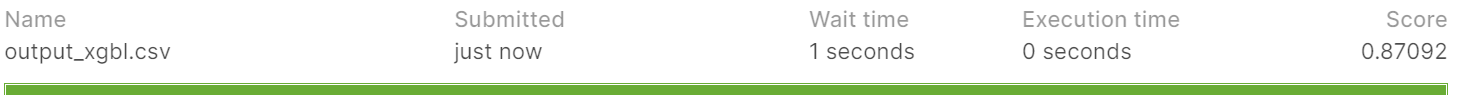

In [24]:
from IPython.display import Image
Image(filename = "xgbl.png", width=900)
# Use only pseudo labeling on one-hot encoded dataset

The AUC score does not seem to improve from the XGBoost model fitted with the original training data with <b>0.87929</b>. 

### Try 3-1: I created a new feature using predict_proba on for both the training and testing data to fit and predict 

In [25]:
df_onehot_train_new['prob'] = y_pred_prob_new
df_test_onehot['prob'] = y_pred_xgb3
print(df_onehot_train_new.shape)

(32768, 177)


In [26]:
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='auc', use_label_encoder=False)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
skf_xgb_scores = []
skf_xgb_rocs = []

for train_index, test_index in skf.split(df_onehot_train_new, y_label_new):
    x_train_fold, x_test_fold = df_onehot_train_new.iloc[train_index,], df_onehot_train_new.iloc[test_index,]
    y_train_fold, y_test_fold = y_label_new[train_index], y_label_new[test_index]
    xgb_model.fit(x_train_fold, y_train_fold)
    skf_xgb_scores.append(xgb_model.score(x_test_fold, y_test_fold))
    skf_xgb_rocs.append(roc_auc_score(y_test_fold, xgb_model.predict_proba(x_test_fold)[:,1]))
    
eval_skf(skf_xgb_scores, skf_xgb_rocs)

List of ROCs: [0.9992291756997639, 0.9990015416486004, 0.9967962615021438, 0.9980066965361083, 0.9993640699523052, 0.9980729392494099, 0.9986895986895987, 0.9997591174061762, 0.9989805701525505, 0.9994320319421353]
Overall ROCs: 99.87332002778793 %


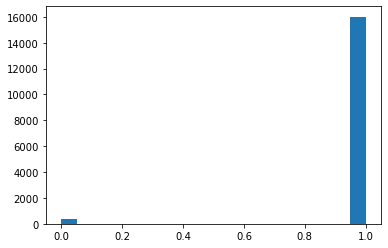

,Id,Y
0,16384,0.999989
1,16385,0.999999
2,16386,0.999998
3,16387,0.999997
4,16388,0.999996


In [27]:
# Fit the xgb model with new train data and predict only the test data probabilities
xgb_model.fit(df_onehot_train_new, y_label_new)
y_pred_prob_xgblp = xgb_model.predict_proba(df_test_onehot)[:,1]
#y_pred_prob_xgb4.shape # This is the pseudo label with test data
plt.hist(y_pred_prob_xgblp, bins=20)
plt.show()

# save probability predictions and submit it to kaggle
output_xgblp = pd.DataFrame({'Id':df_test.index, 'Y':y_pred_prob_xgblp})
#output_xgblp.to_csv("output_xgblp.csv", index = False)
output_xgblp.head()

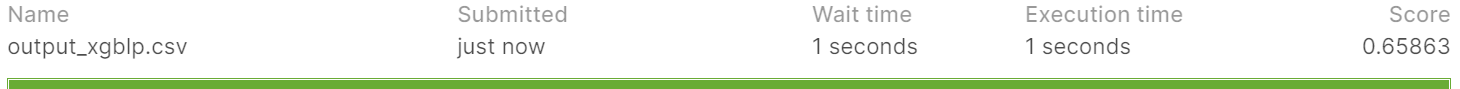

In [28]:
from IPython.display import Image
Image(filename = "xgblp.png", width=900)
# Use only pseudo labeling and predict proba feature in one-hot encoded dataset

Adding the new feature of predict probabilities from the model with training and testing data <b>does not</b> help increase the AUC score. 

### Try 4: Select only features that I would use to train the model and make predictions (somewhat worked) 

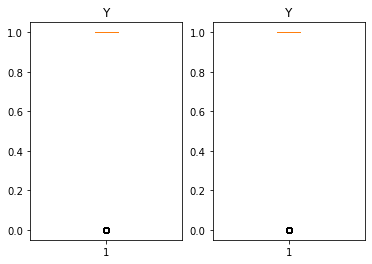

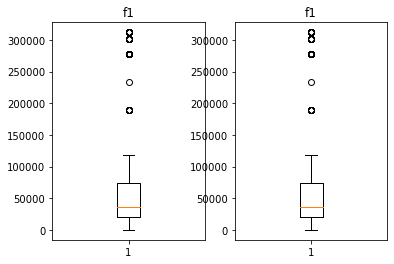

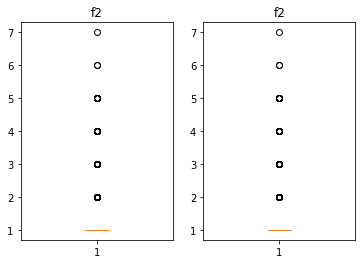

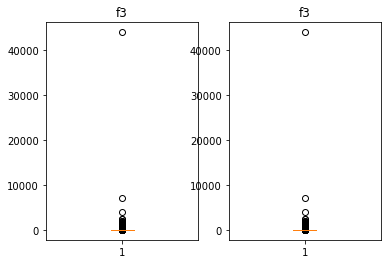

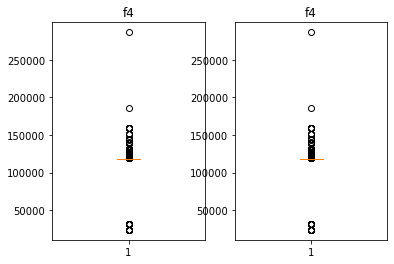

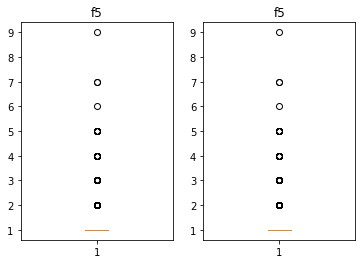

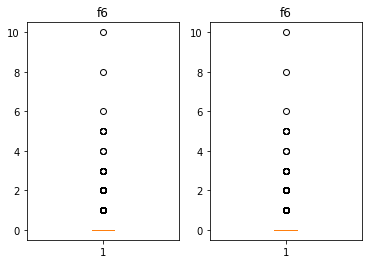

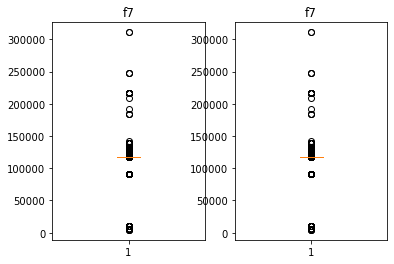

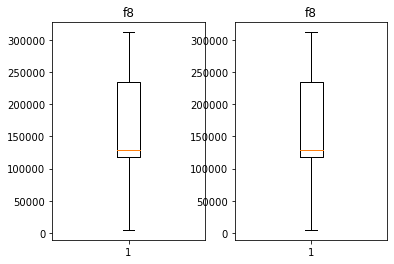

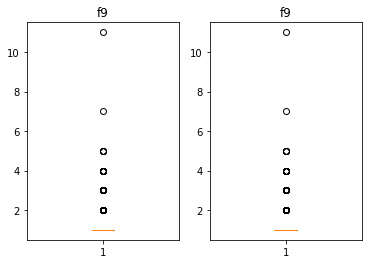

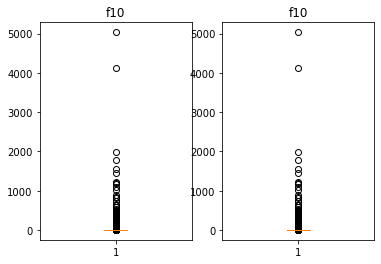

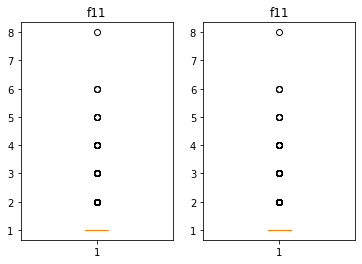

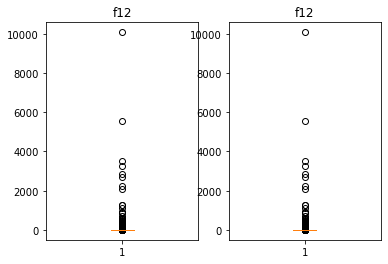

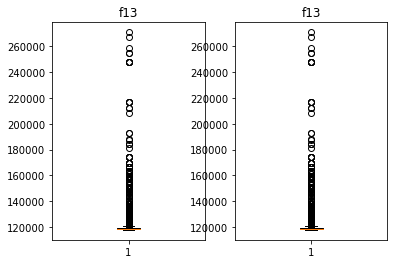

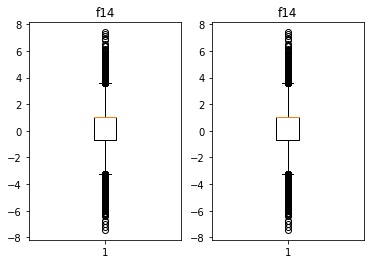

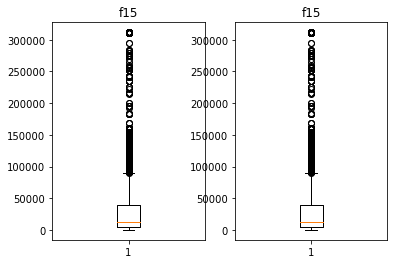

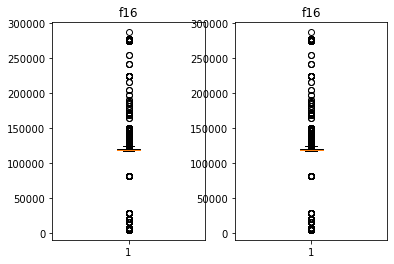

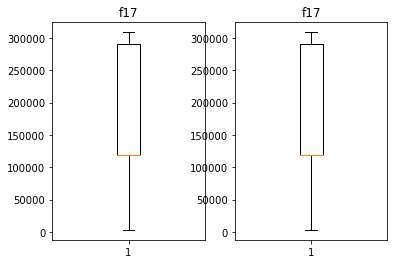

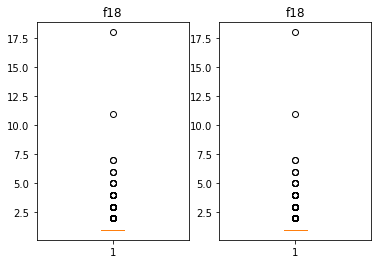

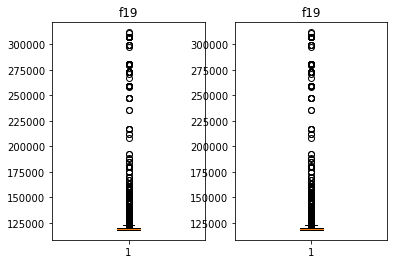

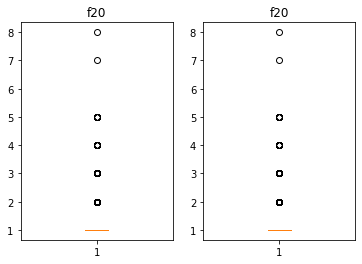

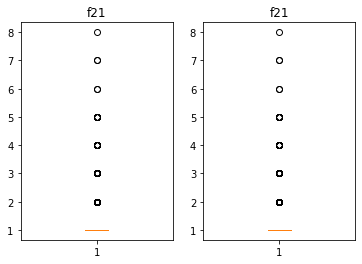

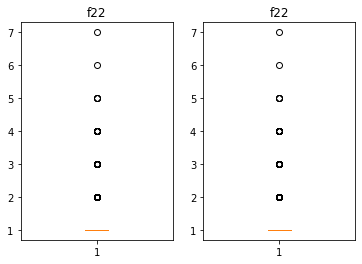

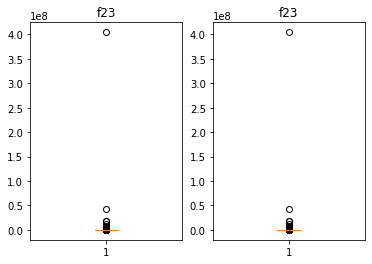

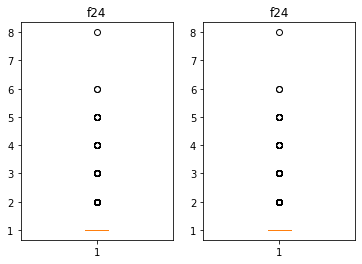

In [29]:
# boxplot
for col in df_all.columns: 
    plt.subplot(1, 2, 1)
    plt.boxplot(df_all[col])
    plt.title(col)
    plt.subplot(1, 2, 2)
    plt.boxplot(df_all[col])
    plt.title(col)
    plt.show()

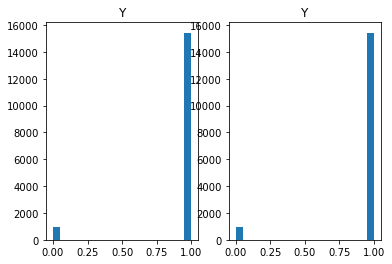

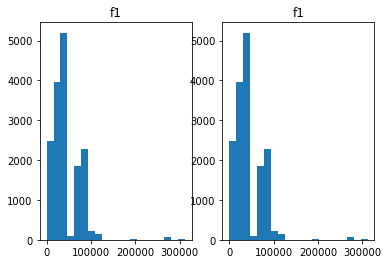

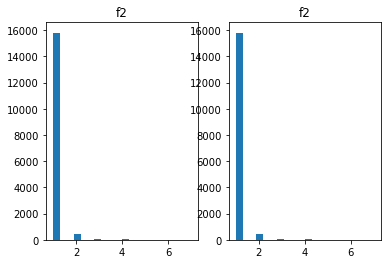

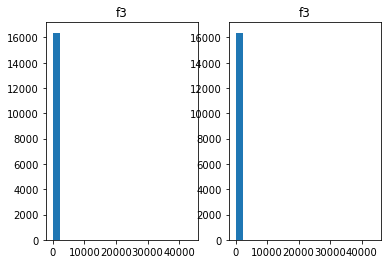

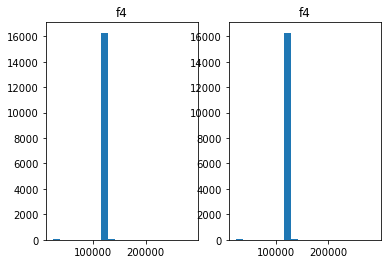

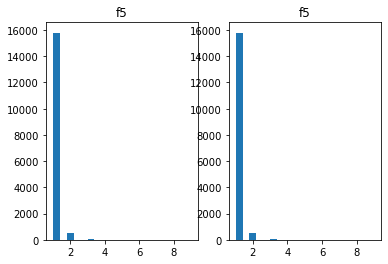

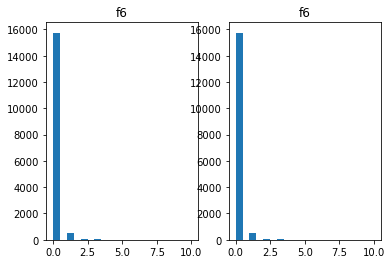

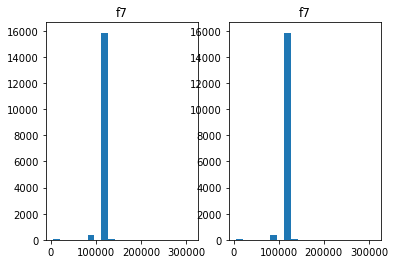

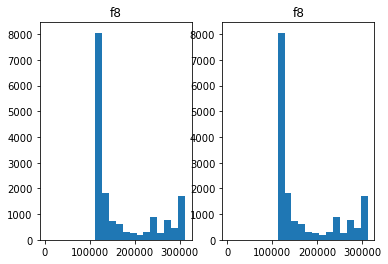

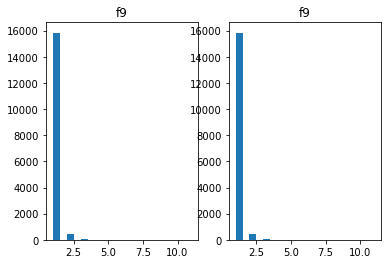

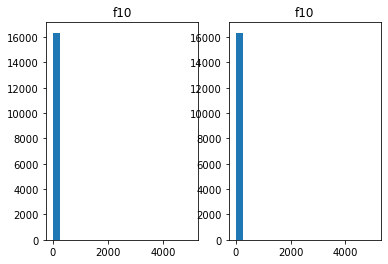

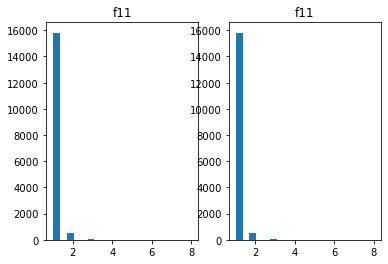

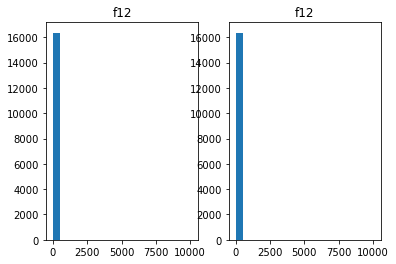

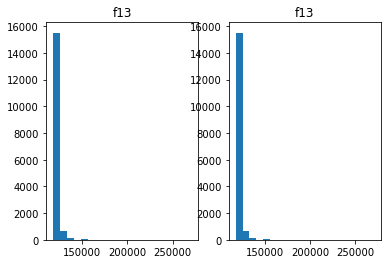

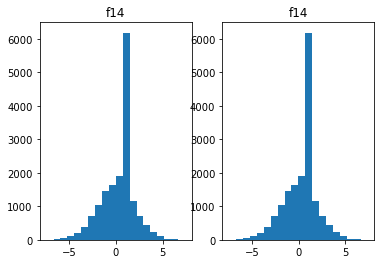

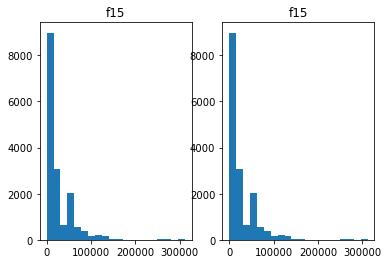

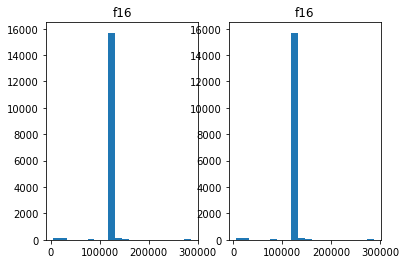

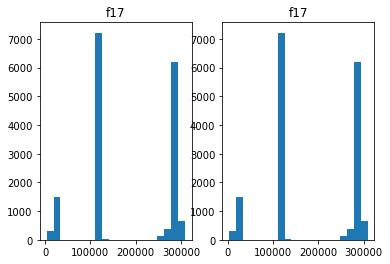

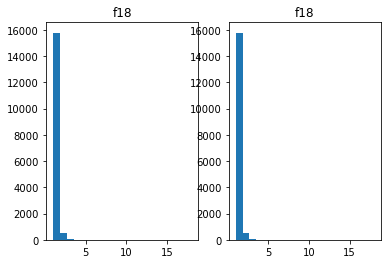

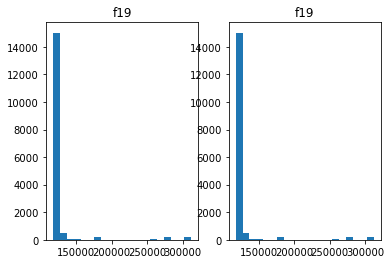

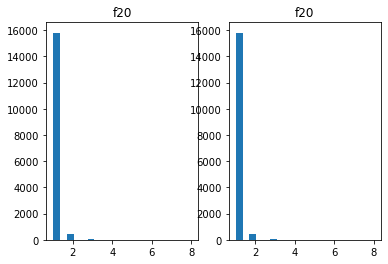

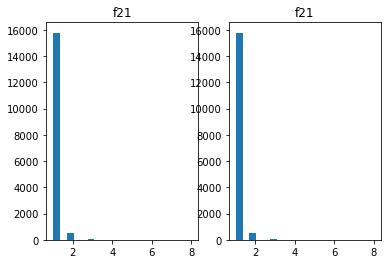

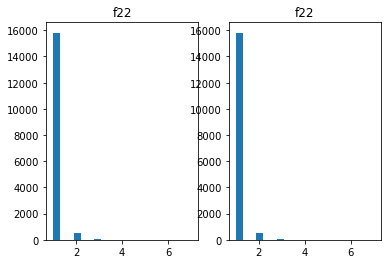

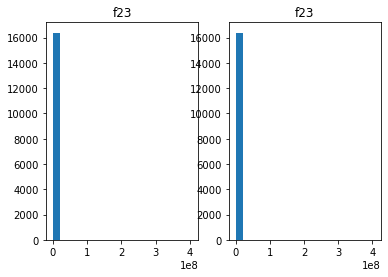

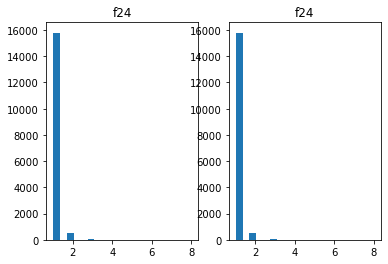

In [30]:
# histogram
for col in df_all.columns: 
    plt.subplot(1, 2, 1)
    plt.hist(df_all[col], bins=20)
    plt.title(col)
    plt.subplot(1, 2, 2)
    plt.hist(df_all[col], bins=20)
    plt.title(col)
    plt.show()

With the boxplots and histograms printed out, I tried to discern if there are features that show different distributions between labels 0 and 1 and just use those features to train and predict. 

In [31]:
cols = ['f1', 'f3', 'f4', 'f6', 'f7', 'f8', 'f10', 
       'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f24']

In [32]:
df_col = df[[*cols]]
df_test_col = df_test[[*cols]]
print(df_col.shape)
print(df_test_col.shape)

(16383, 14)
(16385, 14)


In [33]:
xgb_model4 = xgb.XGBClassifier(random_state=42, eval_metric='auc', use_label_encoder=False)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
skf_xgb4_scores = []
skf_xgb4_rocs = []

for train_index, test_index in skf.split(df_col, y_label):
    x_train_fold, x_test_fold = df_col.iloc[train_index,], df_col.iloc[test_index,]
    y_train_fold, y_test_fold = y_label.iloc[train_index], y_label.iloc[test_index]
    xgb_model4.fit(x_train_fold, y_train_fold)
    skf_xgb4_scores.append(xgb_model4.score(x_test_fold, y_test_fold))
    skf_xgb4_rocs.append(roc_auc_score(y_test_fold, xgb_model4.predict_proba(x_test_fold)[:,1]))
    
eval_skf(skf_xgb4_scores, skf_xgb4_rocs)

List of ROCs: [0.8803790564494136, 0.8856797109353696, 0.8606285792200709, 0.845152133171646, 0.8944162716348805, 0.883924003138111, 0.8530579527236757, 0.9207968073131629, 0.8437288944980728, 0.8953917522256711]
Overall ROCs: 87.63155161310074 %


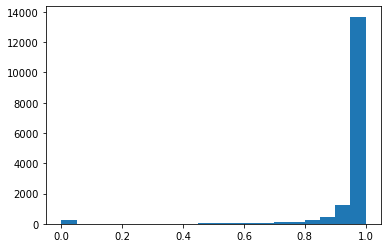

,Id,Y
0,16384,0.904682
1,16385,0.978941
2,16386,0.999695
3,16387,0.999411
4,16388,0.994593


In [34]:
# Now fit the model with the entire training data and predict the probabilities
xgb_model4.fit(df_col, y_label)
y_pred_prob_xgb4 = xgb_model4.predict_proba(df_test_col)[:,1]
plt.hist(y_pred_prob_xgb4, bins=20)
plt.show()

# save probability predictions and submit it to kaggle
output_xgb = pd.DataFrame({'Id':df_test.index, 'Y':y_pred_prob_xgb4})
#output_xgb.to_csv("output_xgb4_col.csv", index = False)
output_xgb.head()

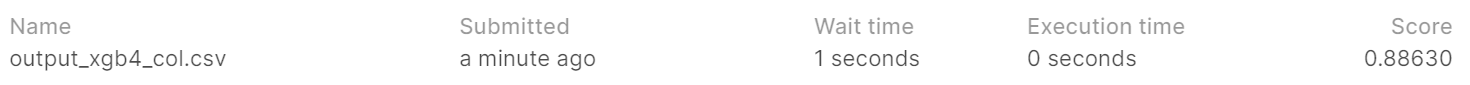

In [35]:
from IPython.display import Image
Image(filename = "xgb4-col.png", width=900)
# Use only the 14 selected features to train and predict

The AUC score I got from my end is 0.8763 for train and split which is smaller than the kaggle one 0.8863, which means that I am not overfitting the data, which is good. The motivation of dropping some features originated from one of my previous submission where I dropped the 'f3' feature since the data was weird. That drop increased my AUC score by a bit, but I couldn't provide a reason justifying the improvement, so I experimented with dropping more features here and explored the effect of such action. 

### Try 5: Hyperparameter tuning on XGBoost model (worked the best)

For this attempt, I dropped feature 3 column because it gave me good results. 

In [36]:
df=df.drop(columns=['f3'])
df_test=df_test.drop(columns=['f3'])
print(df.shape)
print(df_test.shape)

(16383, 23)
(16385, 23)


I experimented with various values of hyperparameters of learning rate, max depth, gamma, n_estimators for the XGBoost classifier model. 

In [37]:
learning_rate = [0.01, 0.05, 0.1, 0.12, 0.15]
max_depth = [3,4,5]
gamma = [0, 0.1, 0.2]
n_estimators = [50, 75, 100, 150, 200, 250, 300]

In [38]:
for lr in learning_rate:
    xgb_model = xgb.XGBClassifier(random_state=42, learning_rate=lr, max_depth=4, n_estimators=200, 
                                  gamma=0.1,eval_metric='auc', use_label_encoder=False)
    
    # Create StratifiedKFold object.
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    skf_xgb_scores = []
    skf_xgb_rocs = []

    for train_index, test_index in skf.split(df, y_label):
        x_train_fold, x_test_fold = df.iloc[train_index,], df.iloc[test_index,]
        y_train_fold, y_test_fold = y_label.iloc[train_index], y_label.iloc[test_index]
        xgb_model.fit(x_train_fold, y_train_fold)
        skf_xgb_scores.append(xgb_model.score(x_test_fold, y_test_fold))
        skf_xgb_rocs.append(roc_auc_score(y_test_fold, xgb_model.predict_proba(x_test_fold)[:,1]))
    
    print(lr)
    eval_skf(skf_xgb_scores, skf_xgb_rocs)
    print("\n")

0.01
List of ROCs: [0.7669757294791383, 0.7957322061630762, 0.79669007362967, 0.7898591665747989, 0.8091238562451769, 0.8003888528839922, 0.7793362213050448, 0.8396971040693113, 0.7844322406794693, 0.8092301395094996]
Overall ROCs: 79.71465590539178 %


0.05
List of ROCs: [0.8464003272429779, 0.8567425688573767, 0.8377829288246524, 0.8298113493550876, 0.8614403042663433, 0.8634171299928369, 0.8249548043797115, 0.8987345226319201, 0.8262271037282123, 0.8692021693897738]
Overall ROCs: 85.14713208668893 %


0.1
List of ROCs: [0.8792473411508044, 0.869082356149441, 0.8489160076356694, 0.8423065262925808, 0.8601174071215962, 0.8754033495923867, 0.8291571443189958, 0.9113483644301941, 0.822792236586281, 0.8868301667974212]
Overall ROCs: 86.2520090007537 %


0.12
List of ROCs: [0.8806858467412053, 0.8719730024543222, 0.8631715298609217, 0.8525004134053578, 0.87914094366663, 0.8732271378381143, 0.8466282361769621, 0.9058498482109356, 0.8281338472558584, 0.8809632636354333]
Overall ROCs: 86.822

I chose a <b>learning rate of 0.1</b> for the final model because I see a jump in ROC score from 0.05 to 0.1, but not so much between the subsequent learning rates. 

I did the same for hyperparameters gamma, max_depth and n_estimators and judged the performances and made my selectoins.  

List of ROCs: [0.8956708481047178, 0.874222797927461, 0.8544382328879193, 0.8598211332818874, 0.8662426965053467, 0.8745028481768258, 0.8455640072312993, 0.915830405566736, 0.8362042500938023, 0.8919875839956339]
Overall ROCs: 87.14484803771629 %


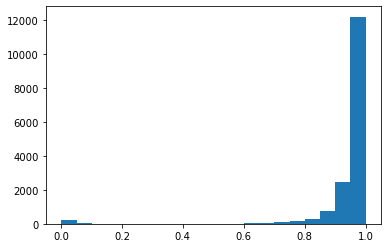

In [39]:
xgb_model = xgb.XGBClassifier(random_state=42, learning_rate=0.1, max_depth=5, gamma=0.2, n_estimators=200, eval_metric='auc', use_label_encoder=False)

# Create StratifiedKFold object to make sure each sample has equal 0 and 1s
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
skf_xgb_scores = []
skf_xgb_rocs = []

for train_index, test_index in skf.split(df, y_label):
    x_train_fold, x_test_fold = df.iloc[train_index,], df.iloc[test_index,]
    y_train_fold, y_test_fold = y_label.iloc[train_index], y_label.iloc[test_index]
    xgb_model.fit(x_train_fold, y_train_fold)
    skf_xgb_scores.append(xgb_model.score(x_test_fold, y_test_fold))
    skf_xgb_rocs.append(roc_auc_score(y_test_fold, xgb_model.predict_proba(x_test_fold)[:,1]))

eval_skf(skf_xgb_scores, skf_xgb_rocs)

# Now fit the model with the entire training data and predict the probabilities for df_test
xgb_model.fit(df, y_label)
y_pred_prob_xgb = xgb_model.predict_proba(df_test)[:,1]
plt.hist(y_pred_prob_xgb, bins=20)
plt.show()

In [40]:
# save probability predictions and submit it to kaggle
output_xgb = pd.DataFrame({'Id':df_test.index, 'Y':y_pred_prob_xgb})
#output_xgb.to_csv("output_xgb_n200_lr01_d5_g02_nof3.csv", index = False)
output_xgb.head()

,Id,Y
0,16384,0.931090
1,16385,0.828299
2,16386,0.999442
3,16387,0.999177
4,16388,0.979760


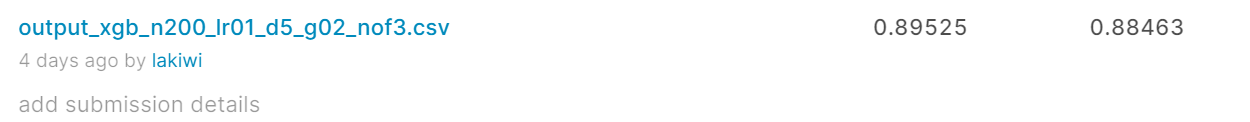

In [41]:
from IPython.display import Image
Image(filename = "best.png", width=900)
# Best model created with selected hyperparameters

The above model is the one that gave me the best score on kaggle, which is also documented in the python code for question 1. 

# Kaggle Report - Reflections

- I was lucky and happened to make the best submission for the private LB scoring based on selecting the highest public LB scores for prediction. 


- However, my second best public LB submission does not give me the second best private LB submission. My second best private LB score was achieved by training with fewer features after closely considering which ones to keep. I think I may be able to get a better private LB score if I user fewer features and the selected hyperparameters from the best private score method. 


- Also, after looking at the private scores for all my submissions, I see that the private LB scores are slightly higher than the public scores for most of the time. This is likely a sign of being conscious of not overfitting. Even though not overfitting seems like a good sign, I think it is the most optimal if my results have a mix of some private scores being higher and some being lower than the public scores, showing that I have some submissions for both overfitting and underfitting. Such indication would help me understand the features in the dataset better and would give me a more informative clue of what action that I did that triggered the overfitting element. 

### Try a post-closing submission where I use only the 14 features and the hyperparameters selected

In [42]:
xgb_model6 = xgb.XGBClassifier(random_state=42, learning_rate=0.1, max_depth=5, gamma=0.2, n_estimators=200, eval_metric='auc', use_label_encoder=False)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
skf_xgb6_scores = []
skf_xgb6_rocs = []

for train_index, test_index in skf.split(df_col, y_label):
    x_train_fold, x_test_fold = df_col.iloc[train_index,], df_col.iloc[test_index,]
    y_train_fold, y_test_fold = y_label.iloc[train_index], y_label.iloc[test_index]
    xgb_model6.fit(x_train_fold, y_train_fold)
    skf_xgb6_scores.append(xgb_model6.score(x_test_fold, y_test_fold))
    skf_xgb6_rocs.append(roc_auc_score(y_test_fold, xgb_model6.predict_proba(x_test_fold)[:,1]))
    
eval_skf(skf_xgb6_scores, skf_xgb6_rocs)

List of ROCs: [0.8927120261794382, 0.8746932097082084, 0.8567221161712572, 0.8580331551096902, 0.8678136368647338, 0.877170242521404, 0.8370228877443121, 0.9182999624791077, 0.8389330422621687, 0.8881024661459221]
Overall ROCs: 87.09502745186242 %


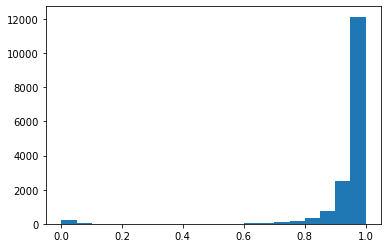

,Id,Y
0,16384,0.925646
1,16385,0.887976
2,16386,0.999360
3,16387,0.998728
4,16388,0.982593


In [43]:
# Now fit the model with the entire training data and predict the probabilities
xgb_model6.fit(df_col, y_label)
y_pred_prob_xgb6 = xgb_model6.predict_proba(df_test_col)[:,1]
plt.hist(y_pred_prob_xgb6, bins=20)
plt.show()

# save probability predictions and submit it to kaggle
output_xgb = pd.DataFrame({'Id':df_test.index, 'Y':y_pred_prob_xgb6})
#output_xgb.to_csv("output_xgb6_col.csv", index = False)
output_xgb.head()

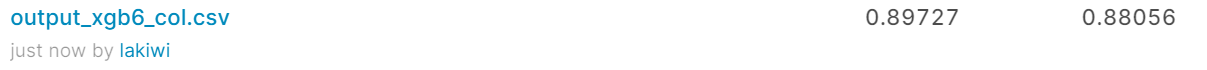

In [44]:
from IPython.display import Image
Image(filename = "xgb6_col.png", width=900)
# Use only the 14 selected features with the selected hyperparameters, private 0.89727 public 0.88056

Even though the public score is not the highest, I am surprised that the private score is the highest, even <b>surpassing my private LB score 0.89525</b>. 